# Kaggle : Mercari Price Suggestion Challenge
## Advanced Data Mining Final Presentation
### 20176005 Jegyeong Kim


In [298]:
import pandas as pd
import numpy as np
from IPython.display import display
import re
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
from gensim.models import Doc2Vec
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from collections import namedtuple
from sklearn.preprocessing import LabelBinarizer
from scipy.sparse import csr_matrix, hstack
import scipy

%matplotlib inline

In [2]:
path = 'C:\\Users\\Rainbow\\Desktop\\adm\\'

In [145]:
train = pd.read_csv(path+'train.tsv', sep='\t')
test = pd. read_csv(path+'test.tsv', sep='\t')

In [146]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [147]:
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [148]:
df = pd.concat([train, test])
df.head()

,brand_name,category_name,item_condition_id,item_description,name,price,shipping,test_id,train_id
0,NaN,Men/Tops/T-shirts,3,No description yet,MLB Cincinnati Reds T Shirt Size XL,10.0,1,NaN,0.0
1,Razer,Electronics/Computers & Tablets/Components & P...,3,This keyboard is in great condition and works ...,Razer BlackWidow Chroma Keyboard,52.0,0,NaN,1.0
2,Target,Women/Tops & Blouses/Blouse,1,Adorable top with a hint of lace and a key hol...,AVA-VIV Blouse,10.0,1,NaN,2.0
3,NaN,Home/Home Décor/Home Décor Accents,1,New with tags. Leather horses. Retail for [rm]...,Leather Horse Statues,35.0,1,NaN,3.0
4,NaN,Women/Jewelry/Necklaces,1,Complete with certificate of authenticity,24K GOLD plated rose,44.0,0,NaN,4.0


In [149]:
del train
del test

In [293]:
train_id = df[df['train_id'].notnull()].index.tolist()[-1]
train_id

1482534

#### preprocessing
1. 특수문자 제거
2. 앞 뒤 공백 제거
3. 소문자 처리

In [150]:
## 특수문자 제거, 앞뒤 공백 제거, 소문자 처리
df['brand_name'] = df['brand_name'].str.lower().str.strip()
df['name'] = df['name'].str.lower().str.strip()
df['item_description'] = df['item_description'].str.lower().str.strip()
df['category_name'] = df['category_name'].str.lower().str.strip()

df.loc[df['brand_name'].notnull(), 'brand_name'] = df.loc[df['brand_name'].notnull(), 'brand_name'].map(lambda x: re.sub(r'\W+', ' ', x))
df['name'] = df['name'].map(lambda x: re.sub(r'\W+', ' ', x))
df.loc[df['item_description'].notnull(), 'item_description'] = df.loc[df['item_description'].notnull(), 'item_description'].map(lambda x: re.sub(r'\W+', ' ', x))
df.head()

,brand_name,category_name,item_condition_id,item_description,name,price,shipping,test_id,train_id
0,NaN,men/tops/t-shirts,3,no description yet,mlb cincinnati reds t shirt size xl,10.0,1,NaN,0.0
1,razer,electronics/computers & tablets/components & p...,3,this keyboard is in great condition and works ...,razer blackwidow chroma keyboard,52.0,0,NaN,1.0
2,target,women/tops & blouses/blouse,1,adorable top with a hint of lace and a key hol...,ava viv blouse,10.0,1,NaN,2.0
3,NaN,home/home décor/home décor accents,1,new with tags leather horses retail for rm eac...,leather horse statues,35.0,1,NaN,3.0
4,NaN,women/jewelry/necklaces,1,complete with certificate of authenticity,24k gold plated rose,44.0,0,NaN,4.0


#  
#  1. EDA

### (1) Null Check
null값 체크

In [8]:
print(df.isnull().sum(), '\n')
print((df.isnull().sum()/len(df)*100).astype(int).astype(str)+' %')

brand_name            928207
category_name           9385
item_condition_id          0
item_description           4
name                       0
price                 693359
shipping                   0
test_id              1482535
train_id              693359
dtype: int64 

brand_name           42 %
category_name         0 %
item_condition_id     0 %
item_description      0 %
name                  0 %
price                31 %
shipping              0 %
test_id              68 %
train_id             31 %
dtype: object


1. brand name
2. category name
3. item_description
에 null값 있음

###  
#### price

count    1482535
mean          26
std           38
min            0
25%           10
50%           17
75%           29
max         2009
Name: price, dtype: int32


Text(0.5,1,'Distribution of the price')

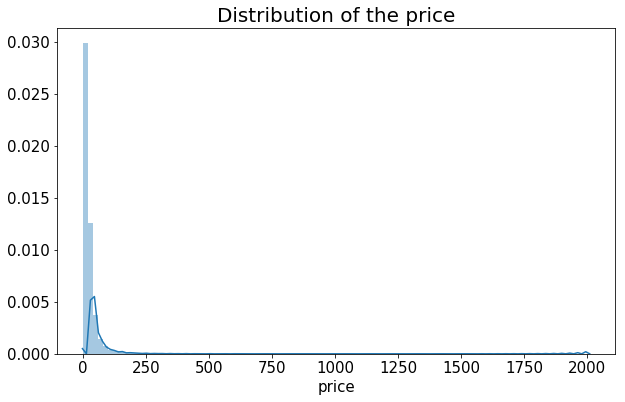

In [151]:
train = df[df['train_id'].notnull()]
print(train['price'].describe().astype(int))
plt.figure(figsize=(10,6))
sns.distplot(train.price, bins=100)
plt.title('Distribution of the price', fontsize =20)

price : 전체적으로 매우 skewed된 데이터 -> log값 취해주기
###  

count    1.482535e+06
mean     2.979059e+00
std      7.492094e-01
min      0.000000e+00
25%      2.397895e+00
50%      2.890372e+00
75%      3.401197e+00
max      7.605890e+00
Name: price, dtype: float64


Text(0.5,1,'Distribution of the log price')

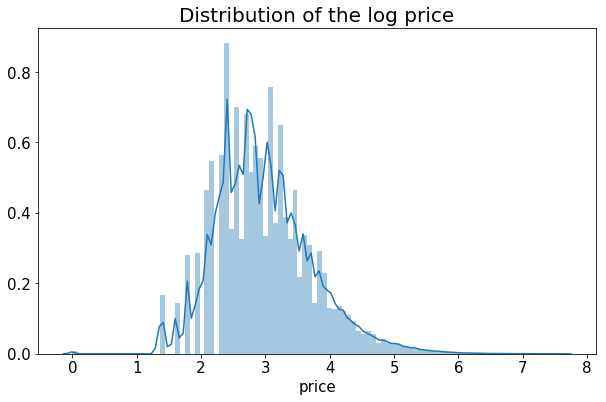

In [145]:
# Price에 로그 씌우기
print(np.log(train['price']+1).describe())
plt.figure(figsize=(10,6))
sns.distplot(np.log(train['price']+1), bins=100)
plt.title('Distribution of the log price', fontsize =20)

In [242]:
train['log_price'] = np.logp1(train['price'])
df.loc[df['train_id'].notnull(), 'log_price'] = np.logp1(df.loc[df['train_id'].notnull(), 'price'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


price에 0값 있음 -> log(price + 1)로 대체  
완전하진 않지만 전체적으로 정규분포를 따름 -> Target Variable로 사용!

##  
### (2) Null Imputation
결측치 대체

#### item_description
nan -> no description yet

In [74]:
len(df[df['item_description'].astype(str)=='no description yet'])

121002

In [153]:
## null 제거
df['item_description'] = df['item_description'].fillna('no description yet')
df['item_description'].isnull().sum()

0

###  
#### category_name
1. Doc2Vec (X)
2. TFIDF - cosine similarity

In [12]:
df[df['category_name'].isnull()].head()

,brand_name,category_name,item_condition_id,item_description,name,price,shipping,test_id,train_id
122,NaN,NaN,3,sizes and info of clothes can be found on thei...,bundle,59.0,0,NaN,122.0
155,NaN,NaN,3,for aferg16,3 nora roberts books,10.0,1,NaN,155.0
258,NaN,NaN,5,powers on no screen display no external damage...,acer laptop,14.0,0,NaN,258.0
984,michael kors,NaN,4,no description yet,authentic brwn michael kors makeup stain,18.0,0,NaN,984.0
1185,nickelodeon,NaN,3,teenage mutant ninja turtle van april o neil f...,teenage mutant ninja turtle van extras,9.0,0,NaN,1185.0


##### Doc2Vec

In [ ]:
class LabeledLineSentence(object):
    def __init__(self, filename):
        self.filename = filename
    def __iter__(self):
        for uid, line in enumerate(open(filename)):
            yield LabeledSentence(words=line.split(), labels=['SENT_%s' % uid])

model = Doc2Vec(alpha=0.025, min_alpha=0.025) 
model.build_vocab(sentences)
for epoch in range(10):
    model.train(sentences)
    model.alpha -= 0.002 
    model.min_alpha = model.alpha  

##### TFIDF - Consine Similarity

name이 너무 짧을 경우 item_description 사용

In [13]:
df.loc[df['name'].str.split(' ').str.len()>1, 'infer'] = df.loc[df['name'].str.split(' ').str.len()>1, 'name'] 
df.loc[df['name'].str.split(' ').str.len()<=1, 'infer'] = df.loc[df['name'].str.split(' ').str.len()<=1, 'item_description'] 

In [261]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

In [15]:
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words=stop_words)
matrix_infer = tfidf.fit_transform(df['infer'])

In [24]:
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words=stop_words, min_df=10)
matrix_name = tfidf.fit_transform(df['name'])

In [25]:
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words=stop_words, min_df=10)
matrix_description = tfidf.fit_transform(df['item_description'])

In [26]:
import pickle

def save_pickle(matrix, filename):
    with open(filename, 'wb') as outfile:
        pickle.dump(matrix, outfile, pickle.HIGHEST_PROTOCOL)
def load_pickle(filename):
    with open(filename, 'rb') as infile:
        matrix = pickle.load(infile)    
    return matrix    

%time save_pickle(matrix_infer, path+'matrix_infer')
%time save_pickle(matrix_name, path+'matrix_name')
%time save_pickle(matrix_description, path+'matrix_discription')

Wall time: 533 ms
Wall time: 2.17 s


In [37]:
from sklearn.metrics.pairwise import linear_kernel
 
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]

###  
유사한 category 뽑아보기

In [47]:
i = 100
print(df.iloc[i]['name'], df.iloc[i]['category_name'])
for index in find_similar(matrix_infer, i, top_n=5):
    print(df.iloc[index]['name'], df.iloc[index]['category_name'])

muscle t shirt women/tops & blouses/t-shirts
muscle t shirt women/tops & blouses/t-shirts
muscle shirt women/tops & blouses/t-shirts
muscle shirt women/tops & blouses/tank, cami
pink muscle shirt women/tops & blouses/t-shirts
pink muscle shirt women/tops & blouses/tank, cami


In [35]:
similar = []
for idx in df[df['category_name'].isnull()].index:
    similar.append(find_similar(matrix_infer, idx, top_n=1))

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500
2520
2540
2560
2580
2600
2620
2640
2660
2680
2700
2720
2740
2760
2780
2800
2820
2840
2860
2880
2900
2920
2940
2960
2980
3000
3020
3040
3060
3080
3100
3120
3140
3160
3180
3200
3220
3240
3260
3280
3300
3320
3340
3360
3380
3400
3420
3440
3460
3480
3500
3520
3540
3560
3580
3600
3620
3640
3660
3680
3700
3720
3740
3760
3780
3800
3820
3840
3860
3880
3900
3920
3940
3960
3980
4000
4020
4040
4060
4080
4100
4120
4140
4160
4180
4200
4

In [154]:
df.loc[df['category_name'].isnull(), 'category_name'] = df.iloc[similar]['category_name'].tolist()

In [155]:
len(df[df['category_name'].isnull()])

279

In [156]:
similar2 = []
for idx in df[df['category_name'].isnull()].index:
    similar2.append(find_similar(matrix_infer, idx, top_n=2)[1])

In [157]:
df.loc[df['category_name'].isnull(), 'category_name'] = df.iloc[similar2]['category_name'].tolist()
len(df[df['category_name'].isnull()])

30

In [158]:
similar3 = []
for idx in df[df['category_name'].isnull()].index:
    similar3.append(find_similar(matrix_infer, idx, top_n=3)[2])

In [159]:
df.loc[df['category_name'].isnull(), 'category_name'] = df.iloc[similar3]['category_name'].tolist()
len(df[df['category_name'].isnull()])

1

In [160]:
similar4 = []
for idx in df[df['category_name'].isnull()].index:
    similar4.append(find_similar(matrix_infer, idx, top_n=4)[3])

In [161]:
df.loc[df['category_name'].isnull(), 'category_name'] = df.iloc[similar4]['category_name'].tolist()
len(df[df['category_name'].isnull()])

0

In [163]:
df.to_csv(path+'category_imputted.csv', index=False)

In [257]:
len(df['category_name'].unique())

1310

In [189]:
df[df['category_name'].str.split('/').str.len()>3]['category_name'].unique()

array(['electronics/computers & tablets/ipad/tablet/ebook readers',
       'sports & outdoors/exercise/dance/ballet',
       'electronics/computers & tablets/ipad/tablet/ebook access',
       'sports & outdoors/outdoors/indoor/outdoor games',
       'men/coats & jackets/varsity/baseball',
       'men/coats & jackets/flight/bomber',
       'handmade/housewares/entertaining/serving'], dtype=object)

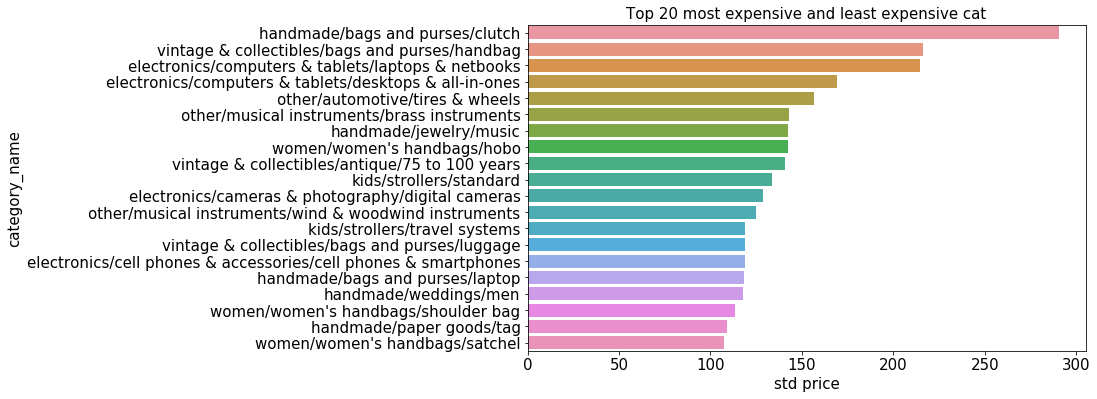

In [260]:
train = df[df['train_id'].notnull()]
group = train.groupby (train['category_name'])
ranking = pd.DataFrame(group.price.std())
ranking.reset_index(level = 0, inplace=True)
ranking = ranking.sort_values(by='price', ascending = False)[:20]
plt.figure(figsize=(10,6))
sns.barplot(x = 'price', y = 'category_name', data = ranking, orient = 'h')
plt.title('Top 20 most expensive and least expensive cat', fontsize = 15)
plt.ylabel('category_name', fontsize = 15)
plt.xlabel('std price', fontsize = 15)
plt.show()

In [239]:
df['cat1'], df['cat2'], df['cat3'] = zip(*df['category_name'].apply(lambda x: x.split('/')))
df.head()

,brand_name,category_name,item_condition_id,item_description,name,price,shipping,test_id,train_id,category_name2,cat1,cat2,cat3
0,mlb,men/tops/t-shirts,3,no description yet,mlb cincinnati reds t shirt size xl,10.0,1,NaN,0.0,"[men, tops, t-shirts]",men,tops,t-shirts
1,razer,electronics/computers & tablets/components & p...,3,this keyboard is in great condition and works ...,razer blackwidow chroma keyboard,52.0,0,NaN,1.0,"[electronics, computers & tablets, components ...",electronics,computers & tablets,components & parts
2,target,women/tops & blouses/blouse,1,adorable top with a hint of lace and a key hol...,ava viv blouse,10.0,1,NaN,2.0,"[women, tops & blouses, blouse]",women,tops & blouses,blouse
3,nobrand,home/home d?cor/home d?cor accents,1,new with tags leather horses retail for rm eac...,leather horse statues,35.0,1,NaN,3.0,"[home, home d?cor, home d?cor accents]",home,home d?cor,home d?cor accents
4,nobrand,women/jewelry/necklaces,1,complete with certificate of authenticity,24k gold plated rose,44.0,0,NaN,4.0,"[women, jewelry, necklaces]",women,jewelry,necklaces


In [259]:
print('length of sub-categories : ', len(df.cat1.unique()), len(df.cat2.unique()), len(df.cat3.unique()))

length of sub-categories :  10 113 881


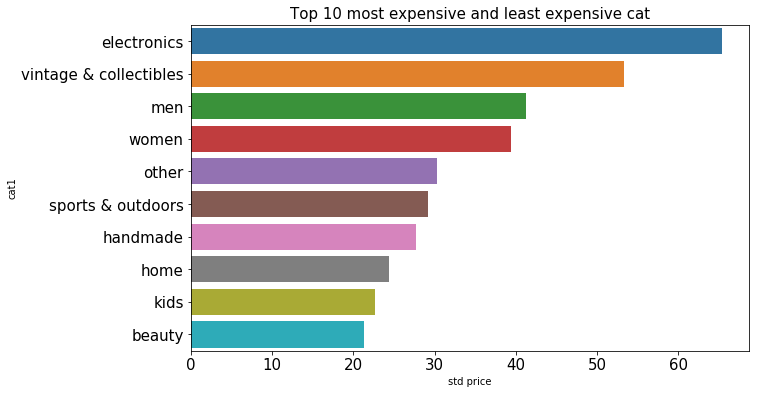

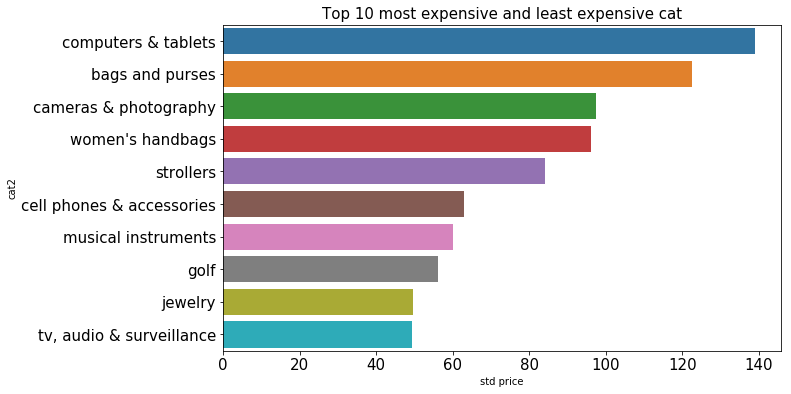

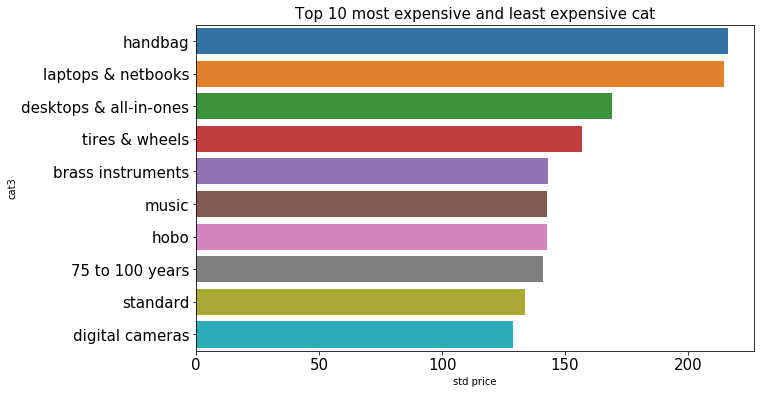

In [252]:
for cat in ['cat1', 'cat2', 'cat3']:
    group = train.groupby (train[cat])
    ranking = pd.DataFrame(group.price.std())
    ranking.reset_index(level = 0, inplace=True)
    ranking = ranking.sort_values(by='price', ascending = False)[:10]
    plt.figure(figsize=(10,6))
    sns.barplot(x = 'price', y = cat, data = ranking, orient = 'h')
    plt.title('Top 10 most expensive and least expensive cat', fontsize = 15)
    plt.ylabel(cat, fontsize = 10)
    plt.xlabel('std price', fontsize = 10)
    plt.show()

In [ ]:
df['']

###  
#### brand_name

In [162]:
df[df['brand_name'].isnull()].head()

,brand_name,category_name,item_condition_id,item_description,name,price,shipping,test_id,train_id
0,NaN,men/tops/t-shirts,3,no description yet,mlb cincinnati reds t shirt size xl,10.0,1,NaN,0.0
3,NaN,home/home décor/home décor accents,1,new with tags leather horses retail for rm eac...,leather horse statues,35.0,1,NaN,3.0
4,NaN,women/jewelry/necklaces,1,complete with certificate of authenticity,24k gold plated rose,44.0,0,NaN,4.0
5,NaN,women/other/other,3,banana republic bottoms candies skirt with mat...,bundled items requested for ruie,59.0,0,NaN,5.0
9,NaN,vintage & collectibles/collectibles/doll,3,i realized his pants are on backwards after th...,porcelain clown doll checker pants vtg,8.0,0,NaN,9.0


In [79]:
print('고유 브랜드 개수 :', len(df.brand_name.unique()))

고유 브랜드 개수 : 5286



1. name, item_description으로부터 brand_name impuation

In [50]:
brand_name = pd.DataFrame(df['brand_name'].value_counts())
brand_name.reset_index(inplace=True)
brand_name.columns = ['brand', 'count']
brand_name['brand'] = brand_name['brand'].str.lower()
brand_name = brand_name[~brand_name['brand'].str.contains('\|')]

## 브랜드 frequency가 최소 100개 이상인 브랜드만 impuation
brands = brand_name[(brand_name['count']>100)]['brand'].tolist()
brands[:10]

['nike',
 'pink',
 'victoria s secret',
 'lularoe',
 'apple',
 'forever 21',
 'nintendo',
 'lululemon',
 'michael kors',
 'american eagle']

In [18]:
## 'brand + 공백' or '공백 + brand + 공백'으로 search -> brand만 했을 경우 오류 많음
## ex) mac -> macadamia 잡아냄

brand_null = df.loc[df['brand_name'].isnull(),]
i=0
for brand in brands:
    brand_null.loc[(brand_null['name'].str.startswith(brand+' '))|\
                   (brand_null['name'].str.contains(' '+brand+' ')), 'brand1'] = brand
    i+=1
    if i%100 == 0:
        print(i)

brand_null = brand_null.loc[brand_null['item_description'].notnull(),]
brand_null['item_description'] = brand_null['item_description'].str.lower()
i=0
for brand in brands:
    brand_null.loc[(brand_null['item_description'].str.startswith(brand+' '))|\
                   (brand_null['item_description'].str.contains(' '+brand+' ')), 'brand2'] = brand
    i+=1
    if i%100 == 0:
        print(i)

100
200
300
400
500
600


In [209]:
brand_null = pd.read_csv(path+'null.csv', encoding='cp949')

In [210]:
# 최소 3글자 이상인 brand_name 사용 -> 일상적으로 사용되는 단어인 so, op, m 같은 브랜드가 잡힘
brand_null.loc[brand_null['brand1'].str.len()<3, 'brand1'] = np.nan
brand_null.loc[brand_null['brand2'].str.len()<3, 'brand2'] = np.nan

In [211]:
# 일상 단어 제외 -> pink, all, always, art, bic, vintage...
drop_list = ['pink', 'all', 'always', 'art', 'bic', 'vintage', 'born', 'e.l.f.', 'supreme', 'htc']
brand_null.loc[brand_null['brand1'].isin(drop_list), 'brand1'] = np.nan
brand_null.loc[brand_null['brand2'].isin(drop_list), 'brand2'] = np.nan

In [212]:
# imputation
brand_null.loc[brand_null['brand1'].notnull() \
               & brand_null['brand2'].isnull(), 'brand_name']\
               = brand_null.loc[brand_null['brand1'].notnull() & brand_null['brand2'].isnull(), 'brand1']

brand_null.loc[brand_null['brand1'].isnull() \
               & brand_null['brand2'].notnull(), 'brand_name']\
               = brand_null.loc[brand_null['brand1'].isnull() & brand_null['brand2'].notnull(), 'brand2']

brand_null.loc[brand_null['brand1'].notnull() \
               & brand_null['brand2'].notnull(), 'brand_name']\
               = brand_null.loc[brand_null['brand1'].isnull() & brand_null['brand2'].notnull(), 'brand2']
               
brand_null.loc[(brand_null['brand1'].notnull() & brand_null['brand2'].notnull())\
               & (brand_null['brand1'] == brand_null['brand2']), 'brand_name']\
               = brand_null.loc[(brand_null['brand1'].notnull() & brand_null['brand2'].notnull())\
               & (brand_null['brand1'] == brand_null['brand2']), 'brand1']
               

brand_null.loc[(brand_null['brand1'].notnull() & brand_null['brand2'].notnull())\
               & (brand_null['brand1'] != brand_null['brand2']), 'brand_name']\
               = brand_null.loc[(brand_null['brand1'].notnull() & brand_null['brand2'].notnull())\
               & (brand_null['brand1'] != brand_null['brand2']), 'brand1']

In [213]:
df.loc[(df['brand_name']=='mac')&(df['category_name'].str.contains('elec')), 'brand_name'] = 'apple'

In [214]:
# 휴대폰 케이스 없애기
brand_null.loc[(brand_null['name'].str.lower().str.contains('iphone')\
        | brand_null['name'].str.lower().str.contains('galaxy')\
        | brand_null['name'].str.lower().str.contains('samsung')\
        | brand_null['name'].str.lower().str.contains('apple'))\
       & (brand_null['name'].str.lower().str.contains('case')), 'brand_name'] = np.nan

In [215]:
df.loc[df['brand_name'].isnull(), 'brand_name'] = brand_null['brand_name'].tolist()
print('brand name이 imputation된 상품 개수 : ', len(brand_null[brand_null['brand_name'].notnull()]))
df.head()

brand name이 imputation된 상품 개수 :  211081


,brand_name,category_name,item_condition_id,item_description,name,price,shipping,test_id,train_id
0,mlb,men/tops/t-shirts,3,no description yet,mlb cincinnati reds t shirt size xl,10.0,1,NaN,0.0
1,razer,electronics/computers & tablets/components & p...,3,this keyboard is in great condition and works ...,razer blackwidow chroma keyboard,52.0,0,NaN,1.0
2,target,women/tops & blouses/blouse,1,adorable top with a hint of lace and a key hol...,ava viv blouse,10.0,1,NaN,2.0
3,NaN,home/home d?cor/home d?cor accents,1,new with tags leather horses retail for rm eac...,leather horse statues,35.0,1,NaN,3.0
4,NaN,women/jewelry/necklaces,1,complete with certificate of authenticity,24k gold plated rose,44.0,0,NaN,4.0


In [216]:
print('brand_name이 nan인 상품 개수 : ', len(df[df['brand_name'].astype(str)=='nan']))

brand_name이 nan인 상품 개수 :  717126


In [217]:
df['brand_name'] = df['brand_name'].fillna('nobrand')

In [218]:
# 같은 브랜드인데 다른 이름 처리 -> jordan : jordans
df.loc[df['brand_name']=='jordans', 'brand_name'] = 'jordan'
df.loc[df['brand_name']=='jordans', 'brand_name'] = 'jordan'

df.loc[df['brand_name']=='kate spade new york', 'brand_name'] = 'kate spade'
df.loc[df['brand_name']=='kate spade new york', 'brand_name'] = 'kate spade'

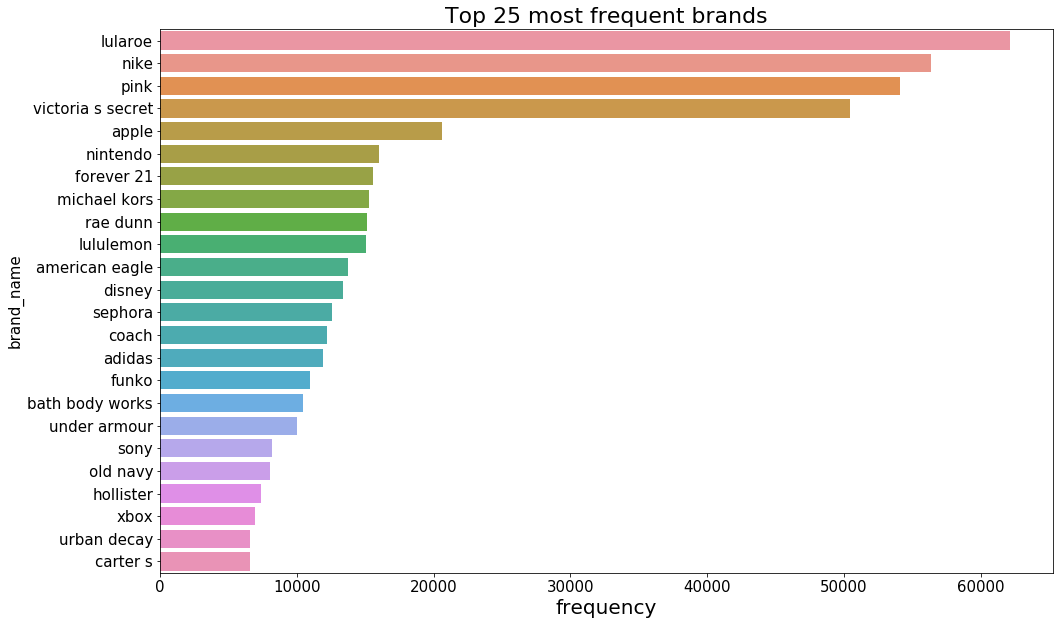

In [174]:
import matplotlib
f,ax = plt.subplots(1,1,figsize=(16,10))
hist = df.groupby(['brand_name'],as_index=False).count().sort_values(by='train_id',ascending=False)[1:25]
sns.barplot(y=hist['brand_name'],x=hist['train_id'],orient='h')
matplotlib.rcParams.update({'font.size': 15})
plt.xlabel('frequency', fontsize=20)
plt.title('Top 25 most frequent brands', fontsize = 22)
plt.show()

Text(0.5,0,'Mean price')

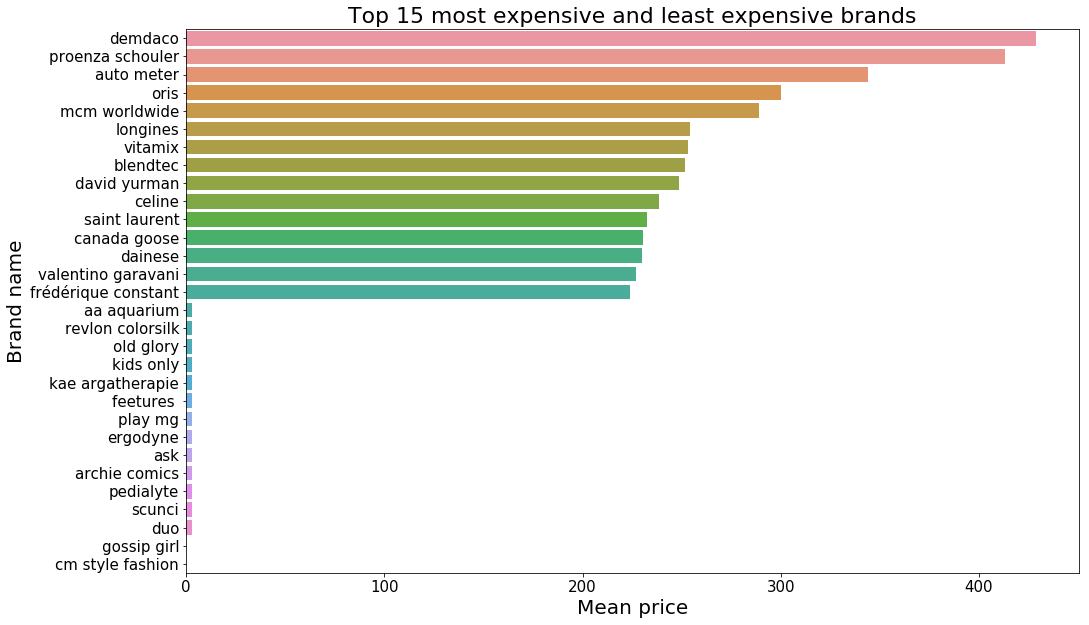

In [175]:
group = train.groupby (train.brand_name)
ranking = pd.DataFrame(group.price.mean())
ranking.reset_index(level = 0, inplace=True)
ranking1 = ranking.sort_values(by='price', ascending = False).head(15)
ranking2 = ranking.sort_values(by='price', ascending = False).tail(15)
ranking = pd.concat([ranking1, ranking2])
plt.figure(figsize=(16,10))
sns.barplot(x = 'price', y = 'brand_name', data = ranking, orient = 'h')
plt.title('Top 15 most expensive and least expensive brands', fontsize = 22)
plt.ylabel('Brand name', fontsize = 20)
plt.xlabel('Mean price', fontsize = 20)

2

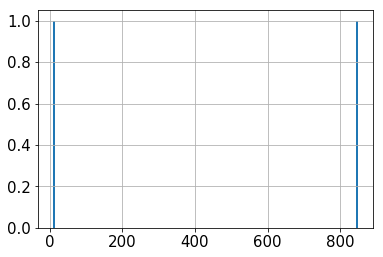

In [180]:
train[train['brand_name']=='demdaco']['price'].hist(bins=200)
len(train[train['brand_name']=='demdaco'])

비싼 브랜드의 경우 frequency가 작은 경우 많음
###  

Text(0.5,0,'Mean price')

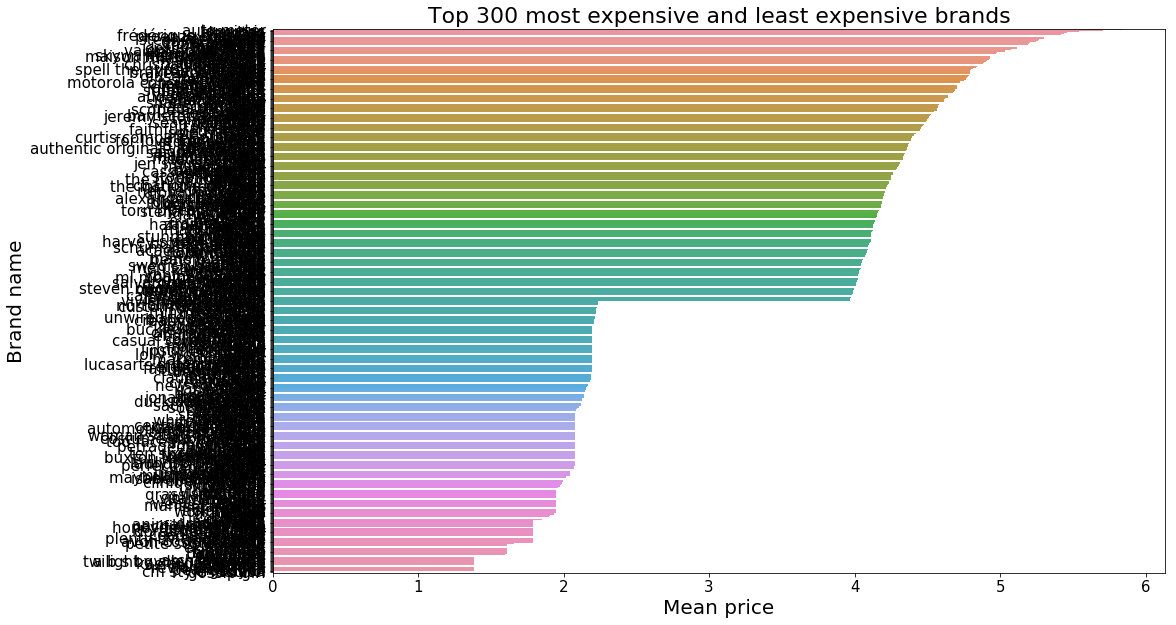

In [128]:
group = train.groupby (train.brand_name)
ranking = pd.DataFrame(group.log_price.mean())
ranking.reset_index(level = 0, inplace=True)
ranking1 = ranking.sort_values(by='log_price', ascending = False).head(300)
ranking2 = ranking.sort_values(by='log_price', ascending = False).tail(300)
ranking = pd.concat([ranking1, ranking2])
plt.figure(figsize=(16,10))
sns.barplot(x = 'log_price', y = 'brand_name', data = ranking.append(ranking2), orient = 'h')
plt.title('Top 300 most expensive and least expensive brands', fontsize = 22)
plt.ylabel('Brand name', fontsize = 20)
plt.xlabel('Mean price', fontsize = 20)

-> Price는 brand의 영향을 많이 받음을 알 수 있음

In [219]:
df[df['brand_name']!='nobrand']['brand_name'].value_counts().describe()

count     5283.000000
mean       276.124929
std       2600.109654
min          1.000000
25%          2.000000
50%          5.000000
75%         26.000000
max      91445.000000
Name: brand_name, dtype: float64

In [223]:
more_than = pd.DataFrame(df['brand_name'].value_counts())
more_than.reset_index(inplace=True)
more_than.columns=['brand_name', 'frequency']
brand_list = more_than[more_than['frequency']>2].iloc[1:]['brand_name'].tolist()
print(len(brand_list))

3433


In [224]:
df.loc[~df['brand_name'].isin(brand_list), 'brand_name'] = 'nobrand'

In [266]:
df.head()

,brand_name,category_name,item_condition_id,item_description,name,price,shipping,test_id,train_id,category_name2,cat1,cat2,cat3,log_price
0,mlb,men/tops/t-shirts,3,no description yet,mlb cincinnati reds t shirt size xl,10.0,1,NaN,0.0,"[men, tops, t-shirts]",men,tops,t-shirts,2.397895
1,razer,electronics/computers & tablets/components & p...,3,this keyboard is in great condition and works ...,razer blackwidow chroma keyboard,52.0,0,NaN,1.0,"[electronics, computers & tablets, components ...",electronics,computers & tablets,components & parts,3.970292
2,target,women/tops & blouses/blouse,1,adorable top with a hint of lace and a key hol...,ava viv blouse,10.0,1,NaN,2.0,"[women, tops & blouses, blouse]",women,tops & blouses,blouse,2.397895
3,nobrand,home/home d?cor/home d?cor accents,1,new with tags leather horses retail for rm eac...,leather horse statues,35.0,1,NaN,3.0,"[home, home d?cor, home d?cor accents]",home,home d?cor,home d?cor accents,3.583519
4,nobrand,women/jewelry/necklaces,1,complete with certificate of authenticity,24k gold plated rose,44.0,0,NaN,4.0,"[women, jewelry, necklaces]",women,jewelry,necklaces,3.806662


In [267]:
df_copy = df.copy()
df.drop(['price', 'category_name', 'category_name2'], axis=1, inplace=True)

###  
##  
## Modeling

In [369]:
matrix_name = load_pickle(path+'matrix_name_02')
matrix_description = load_pickle(path+'matrix_description_02')

In [358]:
df_copy = df_copy[df_copy['price']!=0]
df_copy = df_copy[(df_copy['price']<1200) | (df_copy['price'].isnull())]

In [365]:
dff = df_copy.copy()
len(dff)

2174914

##### 모델에 넣을 수 있도록 encoding

In [360]:
dff['cat1'] = dff['cat1'].astype('category')
dff['cat2'] = dff['cat2'].astype('category')
dff['cat3'] = dff['cat3'].astype('category')
dff['item_condition_id'] = dff['item_condition_id'].astype('category')

cv = CountVectorizer()
%time xcat1 = cv.fit_transform(dff['cat1'])
%time xcat2 = cv.fit_transform(dff['cat2'])
%time xcat3 = cv.fit_transform(dff['cat3'])

Wall time: 5.27 s
Wall time: 6.09 s
Wall time: 6.4 s


In [372]:
dff.to_csv(path+'df02.csv', index=False)

In [361]:
lb = LabelBinarizer(sparse_output=True)
%time xbrand = lb.fit_transform(dff['brand_name'])

Wall time: 9.85 s


In [362]:
lb2 = LabelBinarizer(sparse_output=True)
%time xcondition = lb2.fit_transform(dff['item_condition_id'])

Wall time: 416 ms


In [363]:
xshipping = csr_matrix(dff['shipping']).T

In [370]:
%time sparse = hstack((xcondition, matrix_description, xbrand, xcat1, xcat2, xcat3, matrix_name, xshipping)).tocsr()

Wall time: 15.6 s


In [367]:
matrix_description

<2175894x28161 sparse matrix of type '<class 'numpy.float64'>'
	with 34960579 stored elements in Compressed Sparse Row format>

In [384]:
df_copy.reset_index(inplace=True)
df_copy[df_copy['price'].notnull()]
train_id = df_copy[df_copy['train_id'].notnull()].index[-1]

In [385]:
train_id

1481554

In [386]:
X_train = sparse[:train_id+1]
X_test = sparse[train_id+1:]
y = df[df['train_id'].notnull()]['log_price']

In [387]:
X_train

<1481555x50433 sparse matrix of type '<class 'numpy.float64'>'
	with 39840405 stored elements in Compressed Sparse Row format>

In [339]:
def save_sparse_csr(filename,array):
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape )
save_sparse_csr(path+'test_sparse.txt', X_test)

In [340]:
x = hstack((y_train, X_train)).tocsr()

In [392]:
fromsparsetofile(path+'test.txt', X_test)

 data lenth 18631821
 indices lenth 18631821
 indptr lenth 693360
 row : 500000 
